# sequence prediction sandbox


In [1]:
import torch
from torch import nn

from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import utils as u

In [2]:
# create all possible n-mers for 6 and 8
seqs6 = [''.join(x) for x in product(['A','C','G','T'], repeat=6)]
print('Total 6mers:',len(seqs6))

seqs8 = [''.join(x) for x in product(['A','C','G','T'], repeat=8)]
print('Total 8mers:',len(seqs8))

Total 6mers: 4096
Total 8mers: 65536


In [3]:
# if you want to down select
seqs6_200 = u.downselect_list(seqs6,200)
seqs8_200 = u.downselect_list(seqs8,200)

In [4]:
score_dict = {
    'A':20,
    'C':17,
    'G':14,
    'T':11
}
def score_seqs(seqs):
    data = []
    for seq in seqs:
        score = np.mean([score_dict[base] for base in seq])
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    return df
                  
def score_seqs_motif(seqs):
    data = []
    for seq in seqs:
        score = np.mean([score_dict[base] for base in seq])
        if 'TAT' in seq:
            score += 10
        if 'GCG' in seq:
            score -= 10
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    return df

def score_seqs_ordering(seqs):
    data = []
    i=0
    j=0
    for seq in seqs:
        score = np.mean([score_dict[base] for base in seq])
        if 'AA' in seq and 'GG' in seq:
            if seq.index("AA") < seq.index("GG"):
                score -= 10
                i+=1
        if 'TT' in seq and 'CC' in seq:
            if seq.index("TT") < seq.index("CC"):
                score += 10
                j+=1
        data.append([seq,score])
        
    df = pd.DataFrame(data, columns=['seq','score'])
    print(i)
    print(j)
    return df
    

In [5]:
mer6 = score_seqs(seqs6)
mer6.head()

,seq,score
0,AAAAAA,20.0
1,AAAAAC,19.5
2,AAAAAG,19.0
3,AAAAAT,18.5
4,AAAACA,19.5


In [6]:
mer8 = score_seqs(seqs8)
mer8.head()

,seq,score
0,AAAAAAAA,20.000
1,AAAAAAAC,19.625
2,AAAAAAAG,19.250
3,AAAAAAAT,18.875
4,AAAAAACA,19.625


In [69]:
mer8_motif[mer8['seq']=='TGCGTTTT']

,seq,score,oh
59135,TGCGTTTT,2.5,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."


In [6]:
mer8_motif = score_seqs_ordering(seqs8)


2458
2458


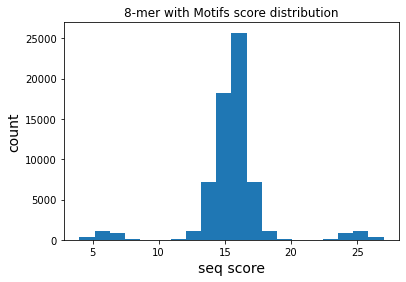

In [7]:
plt.hist(mer8_motif['score'].values,bins=20)
plt.title("8-mer with Motifs score distribution")
plt.xlabel("seq score",fontsize=14)
plt.ylabel("count",fontsize=14)
plt.show()

### Define some basic model archs for Linear and CNN

In [8]:
class DNA_Linear_Shallow(nn.Module):
    def __init__(self, seq_len):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Linear(4*seq_len, 1)

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    
class DNA_Linear_Deep(nn.Module):
    def __init__(self, seq_len,h1_size):
        super().__init__()
        self.seq_len = seq_len
        
        self.lin = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, 1),
            nn.ReLU(inplace=True)
        )

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        out = self.lin(xb)
        #print("Lin out shape:", out.shape)
        return out
    

    
class DNA_CNN(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=32,
                 kernel_size=3):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), 10),
            nn.ReLU(inplace=True),
            nn.Linear(10, 1),
        ) 

    def forward(self, xb):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        #print(xb.shape)
        out = self.conv_net(xb)
        #print("CNN out shape:",out.shape)
        return out

# Try with 8 mers

# Single task Regression with Motifs
### Linear Model

In [23]:
mer8motif_train_dl, \
mer8motif_test_dl, \
mer8motif_train_df, \
mer8motif_test_df = u.build_dataloaders_single(mer8_motif)

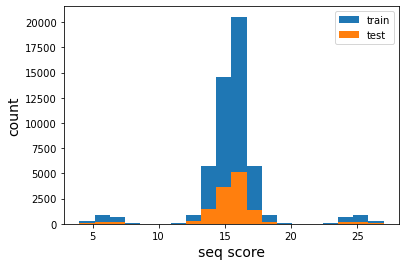

In [24]:
def plot_train_test_hist(train_df, test_df,bins=10):
    ''' Check distribution of train/test scores, sanity check that its not skewed'''
    plt.hist(train_df['score'].values,bins=bins,label="train")
    plt.hist(test_df['score'].values,bins=bins,label='test')
    plt.legend()
    plt.xlabel("seq score",fontsize=14)
    plt.ylabel("count",fontsize=14)
    plt.show()
    
plot_train_test_hist(mer8motif_train_df, mer8motif_test_df,bins=20)

0 6.000132214706556
1 5.995925169075485
2 6.006378930190514
3 5.99878927684245
4 6.000616153057006
5 6.003026496938427
6 5.994943106869281
7 5.989563423647981
8 5.99240191520479
9 5.986974577951766
10 5.990990599445137
11 5.989526872631978
12 5.99053401586156
13 6.016841187359248
14 5.9943463715759036
15 5.997715153780004
16 5.990731946644275
17 5.9997252280078435
18 6.00147558109841
19 6.001449401326975


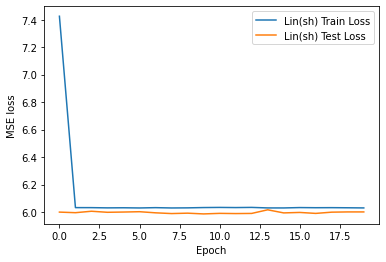

In [25]:
seq_len = len(mer8motif_train_df['seq'].values[0])
hidden_layer_size = 24

mer8motif_model_lin_s = DNA_Linear_Shallow(seq_len)

mer8motif_train_losses_lin_s, mer8motif_test_losses_lin_s = u.run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_lin_s
)

# to plot loss
mer8motif_lin_s_data_label = list(zip([mer8motif_train_losses_lin_s,
                                       mer8motif_test_losses_lin_s], 
                                      ['Lin(sh) Train Loss',
                                       'Lin(sh) Test Loss']))
u.quick_loss_plot(mer8motif_lin_s_data_label)

In [26]:
def quick_test8(model, oracle):
    seqs1 = ['AAAAAAAA', 'CCCCCCCC','GGGGGGGG','TTTTTTTT']
    seqs2 = ['AACCAACA','CCGGCGCG','GGGTAAGG', 'TTTCGTTT','TGTAATAC']
    seqsTAT = ['TATAAAAA','CCTATCCC','GTATGGGG','TTTATTTT']
    seqsGCG = ['AAGCGAAA','CGCGCCCC','GGGCGGGG','TTGCGTTT']
    TATGCG =  ['ATATGCGA','TGCGTATT']

    for seqs in [seqs1, seqs2, seqsTAT, seqsGCG, TATGCG]:
        u.quick_seq_pred(model, seqs, oracle)
        print()

In [27]:
oracle_8mer_motif = dict(mer8_motif[['seq','score']].values)
quick_test8(mer8motif_model_lin_s,oracle_8mer_motif)

AAAAAAAA: pred:17.173 actual:20.000 (2.827)
CCCCCCCC: pred:19.484 actual:17.000 (-2.484)
GGGGGGGG: pred:11.392 actual:14.000 (2.608)
TTTTTTTT: pred:13.704 actual:11.000 (-2.704)

AACCAACA: pred:18.222 actual:18.875 (0.653)
CCGGCGCG: pred:15.130 actual:15.500 (0.370)
GGGTAAGG: pred:13.873 actual:15.125 (1.252)
TTTCGTTT: pred:14.005 actual:12.125 (-1.880)
TGTAATAC: pred:16.483 actual:15.500 (-0.983)

TATAAAAA: pred:17.202 actual:17.750 (0.548)
CCTATCCC: pred:18.046 actual:15.875 (-2.171)
GTATGGGG: pred:12.454 actual:14.000 (1.546)
TTTATTTT: pred:14.096 actual:12.125 (-1.971)

AAGCGAAA: pred:16.228 actual:18.125 (1.897)
CGCGCCCC: pred:18.371 actual:16.250 (-2.121)
GGGCGGGG: pred:12.342 actual:14.375 (2.033)
TTGCGTTT: pred:13.625 actual:12.500 (-1.125)

ATATGCGA: pred:15.400 actual:15.875 (0.475)
TGCGTATT: pred:14.079 actual:13.625 (-0.454)



0 5.323509999735893
1 4.430799448966689
2 4.105143021766027
3 3.8685799408948456
4 3.5520613848308185
5 3.3608772392348616
6 3.8930828120965293
7 3.086225858868205
8 2.9337821562624136
9 2.6656043140270524
10 2.667173142763475
11 2.5487521526323866
12 2.753022906617999
13 2.822373259311265
14 2.2566069256506354
15 2.303262477863988
16 2.180469614287357
17 2.0443926347913557
18 2.295354949725922
19 2.331959787359462


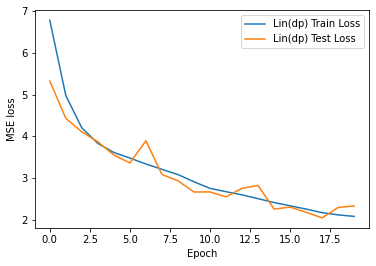

In [28]:
seq_len = len(mer8motif_train_df['seq'].values[0])
hidden_layer_size = 24

mer8motif_model_lin_d = DNA_Linear_Deep(seq_len,hidden_layer_size)

mer8motif_train_losses_lin_d, mer8motif_test_losses_lin_d = u.run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_lin_d
)

# to plot loss
mer8motif_lin_d_data_label = list(zip([mer8motif_train_losses_lin_d,
                                       mer8motif_test_losses_lin_d], 
                                      ['Lin(dp) Train Loss',
                                       'Lin(dp) Test Loss']))
u.quick_loss_plot(mer8motif_lin_d_data_label)

In [29]:
oracle_8mer_motif = dict(mer8_motif[['seq','score']].values)
quick_test8(mer8motif_model_lin_d,oracle_8mer_motif)

AAAAAAAA: pred:22.592 actual:20.000 (-2.592)
CCCCCCCC: pred:17.631 actual:17.000 (-0.631)
GGGGGGGG: pred:17.407 actual:14.000 (-3.407)
TTTTTTTT: pred:10.695 actual:11.000 (0.305)

AACCAACA: pred:19.434 actual:18.875 (-0.559)
CCGGCGCG: pred:16.073 actual:15.500 (-0.573)
GGGTAAGG: pred:14.556 actual:15.125 (0.569)
TTTCGTTT: pred:12.819 actual:12.125 (-0.694)
TGTAATAC: pred:16.072 actual:15.500 (-0.572)

TATAAAAA: pred:17.819 actual:17.750 (-0.069)
CCTATCCC: pred:16.821 actual:15.875 (-0.946)
GTATGGGG: pred:12.512 actual:14.000 (1.488)
TTTATTTT: pred:12.735 actual:12.125 (-0.610)

AAGCGAAA: pred:15.938 actual:18.125 (2.187)
CGCGCCCC: pred:17.825 actual:16.250 (-1.575)
GGGCGGGG: pred:17.258 actual:14.375 (-2.883)
TTGCGTTT: pred:13.414 actual:12.500 (-0.914)

ATATGCGA: pred:18.387 actual:15.875 (-2.512)
TGCGTATT: pred:14.346 actual:13.625 (-0.721)



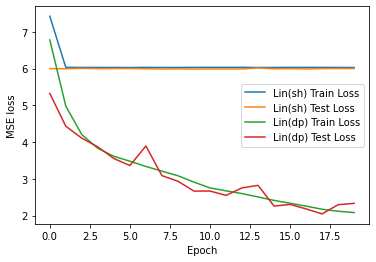

In [30]:
u.quick_loss_plot(
    mer8motif_lin_s_data_label + \
    mer8motif_lin_d_data_label
)

### CNN Model

0 4.772236781837666
1 4.644408462030843
2 1.8820630206834772
3 0.6658529348951089
4 0.9241018841315378
5 0.44226192749597915
6 0.515860958691592
7 0.583955086583512
8 0.3874257557960338
9 0.3484605862385331
10 0.3854254821032913
11 0.3168047094876205
12 0.2863857968004695
13 0.3349937894357426
14 0.26499623968983554
15 0.233858898372995
16 0.24529167007101285
17 0.24227966921137425
18 0.5285671103608146
19 0.1933183347693223


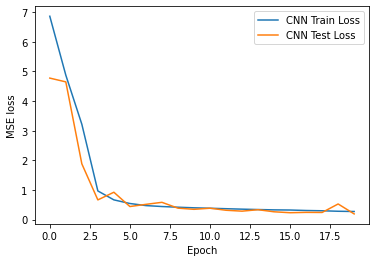

In [48]:
seq_len = len(mer8motif_train_df['seq'].values[0])

mer8motif_model_cnn = DNA_CNN(seq_len, num_filters=31,kernel_size=3)

mer8motif_train_losses_cnn, mer8motif_test_losses_cnn = u.run_model(mer8motif_train_dl, mer8motif_test_dl, mer8motif_model_cnn)

# to plot loss
mer8motif_cnn_data_label = list(zip([mer8motif_train_losses_cnn,mer8motif_test_losses_cnn], ['CNN Train Loss','CNN Test Loss']))
u.quick_loss_plot(mer8motif_cnn_data_label)

In [32]:
quick_test8(mer8motif_model_cnn, oracle_8mer_motif)

AAAAAAAA: pred:20.016 actual:20.000 (-0.016)
CCCCCCCC: pred:17.495 actual:17.000 (-0.495)
GGGGGGGG: pred:14.028 actual:14.000 (-0.028)
TTTTTTTT: pred:10.647 actual:11.000 (0.353)

AACCAACA: pred:18.621 actual:18.875 (0.254)
CCGGCGCG: pred:15.544 actual:15.500 (-0.044)
GGGTAAGG: pred:15.126 actual:15.125 (-0.001)
TTTCGTTT: pred:12.113 actual:12.125 (0.012)
TGTAATAC: pred:15.489 actual:15.500 (0.011)

TATAAAAA: pred:17.841 actual:17.750 (-0.091)
CCTATCCC: pred:15.317 actual:15.875 (0.558)
GTATGGGG: pred:13.930 actual:14.000 (0.070)
TTTATTTT: pred:12.093 actual:12.125 (0.032)

AAGCGAAA: pred:18.070 actual:18.125 (0.055)
CGCGCCCC: pred:16.220 actual:16.250 (0.030)
GGGCGGGG: pred:14.430 actual:14.375 (-0.055)
TTGCGTTT: pred:12.397 actual:12.500 (0.103)

ATATGCGA: pred:15.819 actual:15.875 (0.056)
TGCGTATT: pred:13.482 actual:13.625 (0.143)



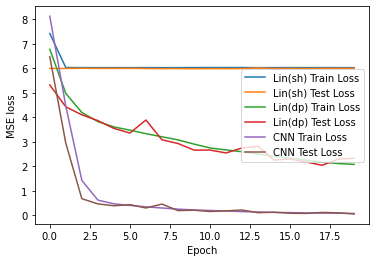

In [33]:
u.quick_loss_plot(
    mer8motif_lin_s_data_label + \
    mer8motif_lin_d_data_label + \
    mer8motif_cnn_data_label
)

Running LinearShallow_8mer


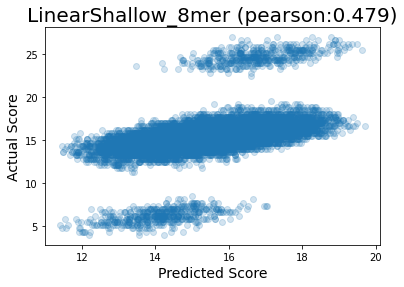

Running LinearDeep_8mer


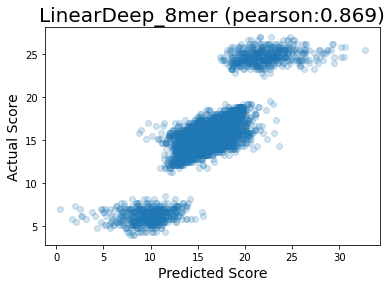

Running CNN_8mer


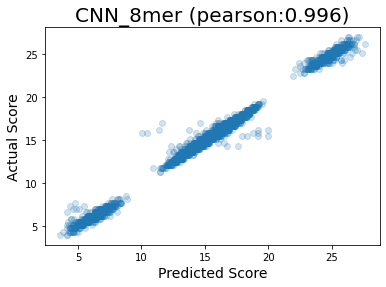

In [34]:
models = [
    ("LinearShallow_8mer",mer8motif_model_lin_s),
    ("LinearDeep_8mer",mer8motif_model_lin_d),
    ("CNN_8mer",mer8motif_model_cnn),
]

seqs = mer8motif_test_df['seq'].values
task = "ordered_motifs"

dfs = u.parity_pred(models, seqs, oracle_8mer_motif,task,alt=True)

# Try LSTMs

In [35]:
class DNA_LSTM(nn.Module):
    def __init__(self,seq_len,hidden_dim=10):
        super().__init__()
        self.seq_len = seq_len

        self.hidden_dim = hidden_dim
        self.hidden = None # when initialized, should be tuple of (hidden state, cell state)
        
        self.rnn = nn.LSTM(4, hidden_dim,batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
            

    
    def init_hidden(self,batch_size):
        # initialize hidden and cell states with 0s
        self.hidden =  (torch.zeros(1, batch_size, self.hidden_dim), 
                        torch.zeros(1, batch_size, self.hidden_dim))
        return self.hidden
        #hidden_state = torch.randn(n_layers, batch_size, hidden_dim)
    

    def forward(self, xb,verbose=False):
        if verbose:
            print("original xb.shape:", xb.shape)
            print(xb) # 11 x 32
        
        # make the one-hot nucleotide vectors group together
        xb = xb.view(-1,self.seq_len,4) 
        if verbose:
            print("re-viewed xb.shape:", xb.shape) # >> 11 x 8 x 4
            print(xb)

        # ** Init hidden/cell states?? **
        batch_size = xb.shape[0]
        if verbose:
            print("batch_size:",batch_size)
        (h,c) = self.init_hidden(batch_size)
         
        # *******
        
        lstm_out, self.hidden = self.rnn(xb, (h,c)) # should this get H and C?
        if verbose:
            #print("lstm_out",lstm_out)
            print("lstm_out shape:",lstm_out.shape) # >> 11, 8, 10
            print("lstm_out[-1] shape:",lstm_out[-1].shape) # >> 8 x 10
            print("lstm_out[-1][-1] shape:",lstm_out[-1][-1].shape) # 10

            print("hidden len:",len(self.hidden)) # 2
            print("hidden[0] shape:", self.hidden[0].shape) # >> 1 x 11 x 10
            print("hidden[0][-1] shape:", self.hidden[0][-1].shape) # >> 11 X 10
            print("hidden[0][-1][-1] shape:", self.hidden[0][-1][-1].shape) # >> 10

            print("*****")
            # These vectors should be the same, right?
            A = lstm_out[-1][-1]
            B = self.hidden[0][-1][-1]
            print("lstm_out[-1][-1]:",A)
            print("self.hidden[0][-1][-1]",B)
            print("==?", A==B)
            print("*****")
        
        # attempt to get the last layer from each last position of 
        # all seqs in the batch? IS this the right thing to get?
        last_layer = lstm_out[:,-1,:] # This is 11X10... and it makes FC out 11X1, which is what I want?
        #last_layer = lstm_out[-1][-1].unsqueeze(0) # this was [10X1]? led to FC outoput being [1]?
        if verbose:
            print("last layer:", last_layer.shape)

        out = self.fc(last_layer) 
        if verbose:
            print("LSTM->FC out shape:",out.shape)   
                                                
        return out

In [36]:
seq_len = len(mer8motif_train_df['seq'].values[0])

mer8motif_model_lstm = DNA_LSTM(seq_len)
mer8motif_model_lstm

DNA_LSTM(
  (rnn): LSTM(4, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [37]:
mer8motif_train_losses_lstm,\
mer8motif_test_losses_lstm = u.run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_lstm
)


0 6.066226420258472
1 7.134065805574289
2 5.093281858171818
3 3.688772716498935
4 2.3693610351552024
5 0.8651701814705619
6 0.5506114203063387
7 0.4761419052716832
8 0.3770416897446199
9 0.3355766340730974
10 0.2688894928420212
11 0.191308830973576
12 0.14412949845162987
13 0.12003217780775582
14 0.09472584741250895
15 0.08987260285650116
16 0.07606526546528108
17 0.06480654577565768
18 0.0696462573148799
19 0.0617824758394193


In [38]:
quick_test8(mer8motif_model_lstm, oracle_8mer_motif)

AAAAAAAA: pred:19.365 actual:20.000 (0.635)
CCCCCCCC: pred:16.688 actual:17.000 (0.312)
GGGGGGGG: pred:14.483 actual:14.000 (-0.483)
TTTTTTTT: pred:12.035 actual:11.000 (-1.035)

AACCAACA: pred:18.941 actual:18.875 (-0.066)
CCGGCGCG: pred:15.608 actual:15.500 (-0.108)
GGGTAAGG: pred:15.400 actual:15.125 (-0.275)
TTTCGTTT: pred:12.599 actual:12.125 (-0.474)
TGTAATAC: pred:15.582 actual:15.500 (-0.082)

TATAAAAA: pred:17.818 actual:17.750 (-0.068)
CCTATCCC: pred:15.979 actual:15.875 (-0.104)
GTATGGGG: pred:14.171 actual:14.000 (-0.171)
TTTATTTT: pred:12.513 actual:12.125 (-0.388)

AAGCGAAA: pred:18.105 actual:18.125 (0.020)
CGCGCCCC: pred:16.489 actual:16.250 (-0.239)
GGGCGGGG: pred:14.618 actual:14.375 (-0.243)
TTGCGTTT: pred:12.885 actual:12.500 (-0.385)

ATATGCGA: pred:15.990 actual:15.875 (-0.115)
TGCGTATT: pred:13.433 actual:13.625 (0.192)



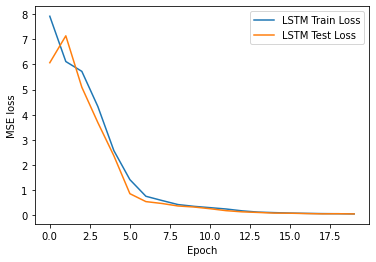

In [39]:
mer8motif_lstm_data_label = list(zip([mer8motif_train_losses_lstm,mer8motif_test_losses_lstm], ['LSTM Train Loss','LSTM Test Loss']))
u.quick_loss_plot(mer8motif_lstm_data_label)

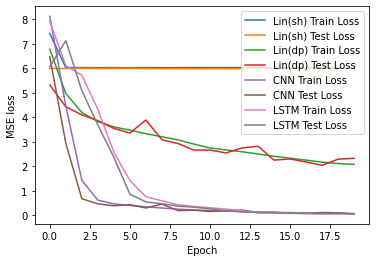

In [40]:
u.quick_loss_plot(
    mer8motif_lin_s_data_label + \
    mer8motif_lin_d_data_label + \
    mer8motif_cnn_data_label + \
    mer8motif_lstm_data_label
)

# Try CNN + LSTM

In [41]:
class DNA_CNNLSTM(nn.Module):
    def __init__(self,
                 seq_len,
                 hidden_dim=10,
                 num_filters=32,
                 kernel_size=3):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_net = nn.Sequential(
            nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.ReLU(inplace=True),
        ) 
        
        self.hidden_dim = hidden_dim
        self.hidden = None # when initialized, should be tuple of (hidden state, cell state)
        
        self.rnn = nn.LSTM(num_filters, hidden_dim,batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
            
    def init_hidden(self,batch_size):
        # initialize hidden and cell states with 0s
        self.hidden =  (torch.zeros(1, batch_size, self.hidden_dim), 
                        torch.zeros(1, batch_size, self.hidden_dim))
        return self.hidden
        #hidden_state = torch.randn(n_layers, batch_size, hidden_dim)

    def forward(self, xb, verbose=False):
        # reshape view to batch_ssize x 4channel x seq_len
        # permute to put channel in correct order
        xb = xb.view(-1,self.seq_len,4).permute(0,2,1) 
        if verbose:
            print("xb reviewed shape:",xb.shape)

        cnn_out = self.conv_net(xb)
        if verbose:
            print("CNN out shape:",cnn_out.shape)
        cnn_out_perm = cnn_out.permute(0,2,1)
        if verbose:
            print("CNN permute out shape:",cnn_out_perm.shape)
        
        batch_size = xb.shape[0]
        if verbose:
            print("batch_size:",batch_size)
        (h,c) = self.init_hidden(batch_size)
        
        lstm_out, self.hidden = self.rnn(cnn_out_perm, (h,c)) # should this get H and C?
        
        last_layer = lstm_out[:,-1,:] # This is 11X10... and it makes FC out 11X1, which is what I want?
        if verbose:
            print("last layer:", last_layer.shape)

        out = self.fc(last_layer) 
        if verbose:
            print("LSTM->FC out shape:",out.shape)        
        
        return out

In [42]:
seq_len = len(mer8motif_train_df['seq'].values[0])

mer8motif_model_cnnlstm = DNA_CNNLSTM(seq_len)
mer8motif_model_cnnlstm

DNA_CNNLSTM(
  (conv_net): Sequential(
    (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU(inplace=True)
  )
  (rnn): LSTM(32, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [43]:
mer8motif_train_losses_cnnlstm,\
mer8motif_test_losses_cnnlstm = u.run_model(
    mer8motif_train_dl, 
    mer8motif_test_dl, 
    mer8motif_model_cnnlstm, 
)


0 5.535336939852741
1 1.4067565537750413
2 0.5687178049030776
3 0.33038449898557687
4 0.19509306158967085
5 0.1622248682527961
6 0.32317826752077705
7 0.1349057947257906
8 0.08259816950219485
9 0.061864514143720864
10 0.05185535632876459
11 0.045784387258920214
12 0.03871987110613722
13 0.03111619192641939
14 0.030069756204802924
15 0.02694088647805375
16 0.023401349424852044
17 0.02147503018715704
18 0.020009071757999323
19 0.019391326278079782


AAAAAAAA: pred:19.793 actual:20.000 (0.207)
CCCCCCCC: pred:16.626 actual:17.000 (0.374)
GGGGGGGG: pred:14.102 actual:14.000 (-0.102)
TTTTTTTT: pred:11.141 actual:11.000 (-0.141)

AACCAACA: pred:18.803 actual:18.875 (0.072)
CCGGCGCG: pred:15.342 actual:15.500 (0.158)
GGGTAAGG: pred:15.278 actual:15.125 (-0.153)
TTTCGTTT: pred:12.336 actual:12.125 (-0.211)
TGTAATAC: pred:15.533 actual:15.500 (-0.033)

TATAAAAA: pred:17.675 actual:17.750 (0.075)
CCTATCCC: pred:15.605 actual:15.875 (0.270)
GTATGGGG: pred:14.029 actual:14.000 (-0.029)
TTTATTTT: pred:12.265 actual:12.125 (-0.140)

AAGCGAAA: pred:18.067 actual:18.125 (0.058)
CGCGCCCC: pred:16.315 actual:16.250 (-0.065)
GGGCGGGG: pred:14.455 actual:14.375 (-0.080)
TTGCGTTT: pred:12.656 actual:12.500 (-0.156)

ATATGCGA: pred:15.837 actual:15.875 (0.038)
TGCGTATT: pred:13.572 actual:13.625 (0.053)



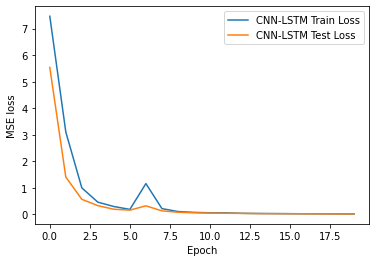

In [44]:
quick_test8(mer8motif_model_cnnlstm, oracle_8mer_motif)

mer8motif_cnnlstm_data_label = list(zip([mer8motif_train_losses_cnnlstm,mer8motif_test_losses_cnnlstm], ['CNN-LSTM Train Loss','CNN-LSTM Test Loss']))
u.quick_loss_plot(mer8motif_cnnlstm_data_label)

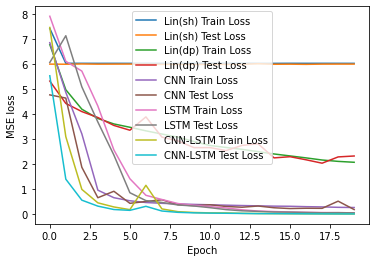

In [49]:
u.quick_loss_plot(
    mer8motif_lin_s_data_label + \
    mer8motif_lin_d_data_label + \
    mer8motif_cnn_data_label + \
    mer8motif_lstm_data_label + \
    mer8motif_cnnlstm_data_label
)

Running LinearShallow_8mer


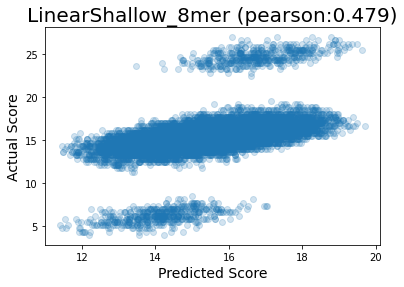

Running LinearDeep_8mer


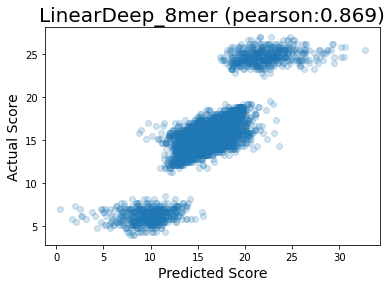

Running CNN_8mer


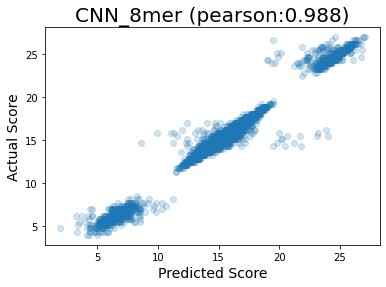

Running LSTM_8mer


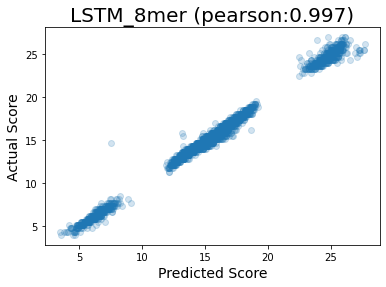

Running CNN+LSTM_8mer


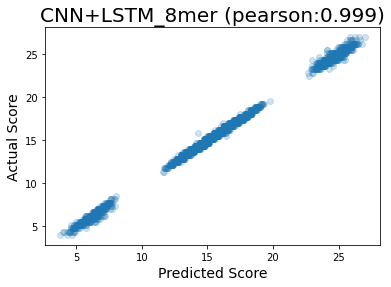

In [56]:
models = [
    ("LinearShallow_8mer",mer8motif_model_lin_s),
    ("LinearDeep_8mer",mer8motif_model_lin_d),
    ("CNN_8mer",mer8motif_model_cnn),
    ("LSTM_8mer",mer8motif_model_lstm),
    ("CNN+LSTM_8mer",mer8motif_model_cnnlstm),
]

seqs = mer8motif_test_df['seq'].values
task = "ordered_motifs"

dfs = u.parity_pred(models, seqs, oracle_8mer_motif,task,alt=True)

In [55]:
oracle_8mer_motif['TTCCACAT']

25.5